In [67]:
# models adapted from:
# https://www.kaggle.com/code/collinpfeifer/5-bird-audio-classifier-model

# # getting data, this was run once to download to a shared google folder and is thus just commented out to show how it was retrieved:

# # uploaded kaggle api json file with:
# from google.colab import files
# files.upload()

# # setting up kaggle api to be used when pulling data
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# %cd /content/drive/MyDrive/ds340/final_project/data
# !kaggle datasets download -d vinayshanbhag/bird-song-data-set

# path = '/content/drive/MyDrive/ds340/final_project/data/'
# import zipfile
# with zipfile.ZipFile(path+'bird-song-data-set.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from glob import glob
import IPython.display as ipd
import tensorflow as tf
from PIL import Image

In [ ]:
df = pd.read_csv('bird_songs_metadata.csv')
df.head(10)

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav
5,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-8.wav
6,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-9.wav
7,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-11.wav
8,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-14.wav
9,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-15.wav


In [ ]:
class_names = df["name"].unique()
print(class_names)

["Bewick's Wren" 'Northern Mockingbird' 'American Robin' 'Song Sparrow'
 'Northern Cardinal']


In [ ]:
df["name"].value_counts()

name
Song Sparrow            1256
Northern Mockingbird    1182
Northern Cardinal       1074
American Robin          1017
Bewick's Wren            893
Name: count, dtype: int64

Getting all the WAV files

In [ ]:
path_to_wav = "/content/drive/MyDrive/ds340/final_project/data/wavfiles/"
datafiles = glob(path_to_wav + "*")

Function to generate a spectrogram

In [ ]:
def generate_spectrogram(file_audio, identifier):
    audio_data, sample_rate = librosa.load(path_to_wav + file_audio)
    spec_mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    spec_mel = librosa.power_to_db(spec_mel, ref=np.max)
    figure, axis = plt.subplots(figsize=(15, 5))
    axis.set_title("Mel Spectrogram")
    plt.suptitle(identifier)
    librosa.display.specshow(spec_mel, x_axis='time', y_axis='log', ax=axis)
    return ipd.Audio(path_to_wav + file_audio, rate=sample_rate)

Generating random spectrogram

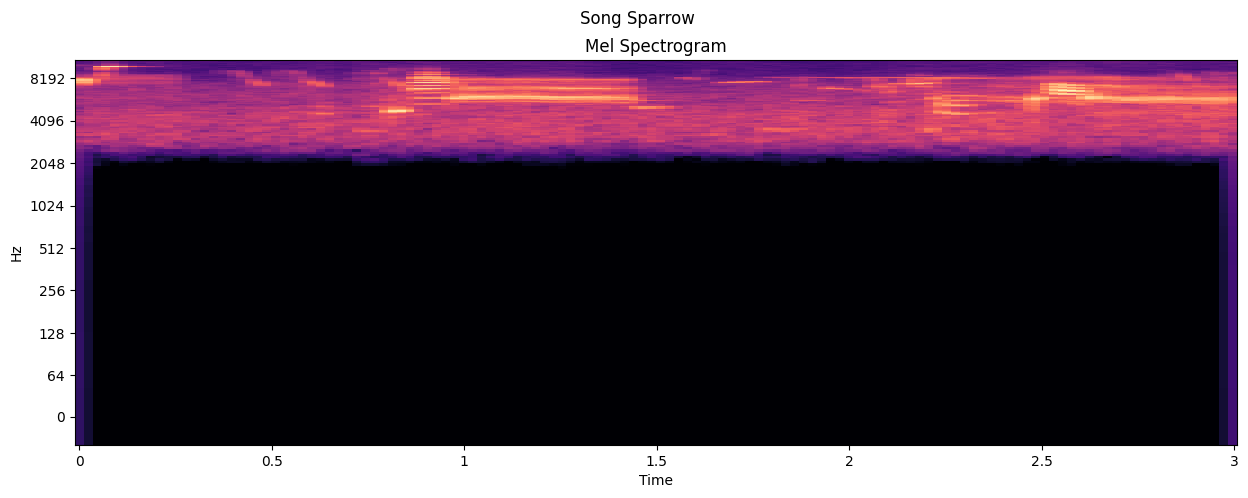

In [ ]:
i = np.random.randint(0, df.shape[0])
generate_spectrogram(df.loc[i, "filename"], df.loc[i, "name"])

Plotting waveform

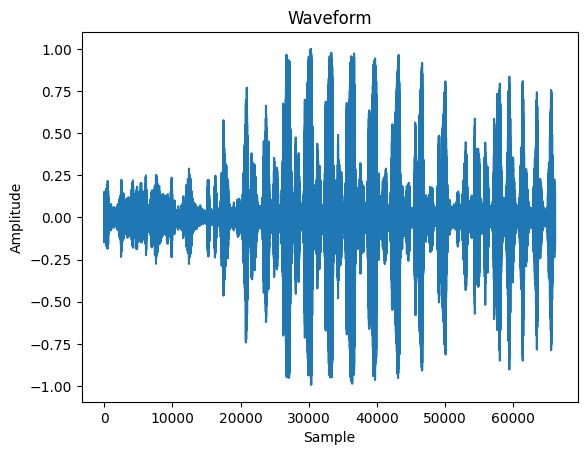

In [ ]:
filename = "/content/drive/MyDrive/ds340/final_project/data/wavfiles/101308-0.wav"
audio_data, sample_rate = librosa.load(filename)

plt.plot(audio_data)
plt.title("Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
filename ="/content/drive/MyDrive/ds340/final_project/data/wavfiles/101308-0.wav"
audio_data, sample_rate = librosa.load(filename)
spectrogram = librosa.stft(audio_data)
spectrogram = np.abs(spectrogram)

plt.imshow(spectrogram, origin='lower', aspect='auto')
plt.title("Spectrogram")
plt.xlabel("Time (samples)")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

Preprocessing function for audio

In [ ]:
def process_audio(audio_file):
    audio_data, sample_rate = librosa.load(audio_file, duration=3)
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec

In [ ]:
filename = '/content/drive/MyDrive/ds340/final_project/data/wavfiles/101308-0.wav'
print(len(process_audio(filename)))
print(len(process_audio(filename)[0]))


128
130


In [ ]:
def process_audio_chromagram(audio_file):
    audio_data, sample_rate = librosa.load(audio_file, duration=3)
    chromagram = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
    return chromagram

Generating a pandas Dataframe to process the data from the CSV and wav files

In [ ]:
df_train = pd.DataFrame({"name": df["name"], "audiopath": path_to_wav + df["filename"]})

df_train["mel_spec"] = df_train["audiopath"].apply(lambda x: process_audio(x))


df_train["chrom"] = df_train["audiopath"].apply(lambda x: process_audio_chromagram(x))

# Using factorize to encode class labels
df_train["class"] = df_train["name"].factorize()[0]

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Shuffle data as it is sorted in order of classes

In [ ]:
from sklearn.utils import shuffle

df_train = shuffle(df_train)
df_train.shape

(5422, 5)

In [66]:
df_train #confirm data was shuffled, shows different values used as X (mel_spec and chrom)

,name,audiopath,mel_spec,chrom,class
209,Bewick's Wren,/content/drive/MyDrive/ds340/final_project/dat...,"[[-53.4862, -59.6931, -80.0, -80.0, -80.0, -80...","[[0.36439613, 0.3333087, 0.27349946, 0.2350308...",0
3971,Song Sparrow,/content/drive/MyDrive/ds340/final_project/dat...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[0.43226713, 0.8027048, 0.8657517, 0.54009455...",3
5194,Northern Cardinal,/content/drive/MyDrive/ds340/final_project/dat...,"[[-39.969715, -45.89396, -56.125572, -54.42084...","[[0.028012123, 0.07741222, 0.24961664, 0.15819...",4
2738,American Robin,/content/drive/MyDrive/ds340/final_project/dat...,"[[-15.274694, -11.69165, -11.52652, -12.73819,...","[[0.002653298, 0.003218504, 0.019947054, 0.008...",2
3632,Song Sparrow,/content/drive/MyDrive/ds340/final_project/dat...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[0.3526373, 0.8048866, 0.8485025, 0.8051663, ...",3
...,...,...,...,...,...
1941,Northern Mockingbird,/content/drive/MyDrive/ds340/final_project/dat...,"[[-46.358406, -52.393745, -80.0, -80.0, -80.0,...","[[0.0046675615, 0.00040293077, 1.17324125e-05,...",1
3022,American Robin,/content/drive/MyDrive/ds340/final_project/dat...,"[[-43.300934, -38.8516, -34.181698, -34.91137,...","[[0.15265878, 0.06611428, 0.047720425, 0.13842...",2
616,Bewick's Wren,/content/drive/MyDrive/ds340/final_project/dat...,"[[-34.79358, -24.870432, -18.586819, -16.26863...","[[0.57545185, 0.5610285, 0.70525706, 0.8979324...",0
1169,Northern Mockingbird,/content/drive/MyDrive/ds340/final_project/dat...,"[[-54.196938, -60.542725, -80.0, -80.0, -80.0,...","[[0.05010733, 0.17822747, 0.85444385, 0.047884...",1


Seperate train and test data

Normalize data and generate Tensorflow datasets

Setting batch sizes

In [73]:
# prepping spec data:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


x_spec_train, x_spec_test, y_spec_train, y_spec_test = train_test_split(df_train["mel_spec"].values, df_train["class"].values, test_size=0.25, random_state=42)

y_spec_test = to_categorical(y_spec_test, num_classes=len(class_names))
y_spec_train = to_categorical(y_spec_train, num_classes=len(class_names))

x_spec_train = np.stack(x_spec_train[:])
x_spec_test = np.stack(x_spec_test[:])

x_spec_train = tf.keras.utils.normalize(x_spec_train)
x_spec_test = tf.keras.utils.normalize(x_spec_test)

train_spec_dataset = tf.data.Dataset.from_tensor_slices((x_spec_train, y_spec_train))
test_spec_dataset = tf.data.Dataset.from_tensor_slices((x_spec_test, y_spec_test))

train_spec_dataset = train_spec_dataset.batch(10)
test_spec_dataset = test_spec_dataset.batch(10)
train_spec_dataset = train_spec_dataset.prefetch(tf.data.AUTOTUNE)
test_spec_dataset = test_spec_dataset.prefetch(tf.data.AUTOTUNE)


In [74]:
# now prepping chrom data
from sklearn.model_selection import train_test_split

x_chrom_train, x_chrom_test, y_chrom_train, y_chrom_test = train_test_split(df_train["chrom"].values, df_train["class"].values, test_size=0.25, random_state=42)

y_chrom_test = to_categorical(y_chrom_test, num_classes=len(class_names))
y_chrom_train = to_categorical(y_chrom_train, num_classes=len(class_names))

x_chrom_train = np.stack(x_chrom_train[:])
x_chrom_test = np.stack(x_chrom_test[:])

x_chrom_train = tf.keras.utils.normalize(x_chrom_train)
x_chrom_test = tf.keras.utils.normalize(x_chrom_test)

train_chrom_dataset = tf.data.Dataset.from_tensor_slices((x_chrom_train, y_chrom_train))
test_chrom_dataset = tf.data.Dataset.from_tensor_slices((x_chrom_test, y_chrom_test))

train_chrom_dataset = train_chrom_dataset.batch(10)
test_chrom_dataset = test_chrom_dataset.batch(10)
train_chrom_dataset = train_chrom_dataset.prefetch(tf.data.AUTOTUNE)
test_chrom_dataset = test_chrom_dataset.prefetch(tf.data.AUTOTUNE)


In [70]:
df_train["mel_spec"].values[0].shape

(128, 130)

In [71]:
df_train["chrom"].values[0].shape

(12, 130)

Setting up model

In [ ]:
import keras
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Reshape, InputLayer, Dropout
from keras.models import Sequential

In [84]:
spec_model = keras.models.Sequential()

spec_model.add(InputLayer(input_shape=(128,130)))
spec_model.add(Reshape((128,130,1)))
spec_model.add(Conv2D(64, (8, 8), input_shape=(128, 130), activation='relu'))
spec_model.add(BatchNormalization())
spec_model.add(MaxPooling2D(pool_size=(2,2)))
spec_model.add(Conv2D(16, (2,2), activation='relu'))
spec_model.add(Flatten())
spec_model.add(Dropout(0.5))
spec_model.add(Dense(128, activation='relu'))
spec_model.add(Dense(5, activation='softmax'))

In [85]:
spec_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 128, 130, 1)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 121, 123, 64)      4160      
                                                                 
 batch_normalization_5 (Bat  (None, 121, 123, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 60, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 59, 60, 16)        4112      
                                                                 
 flatten_5 (Flatten)         (None, 56640)            

In [86]:
spec_model.compile('adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), 'accuracy'])

In [ ]:
chrom_model = keras.models.Sequential()

chrom_model.add(InputLayer(input_shape=(12,130)))
chrom_model.add(Reshape((12,130,1)))
chrom_model.add(Conv2D(64, (8, 8), input_shape=(12, 130), activation='relu'))
chrom_model.add(BatchNormalization())
chrom_model.add(MaxPooling2D(pool_size=(2,2)))
chrom_model.add(Conv2D(16, (2,2), activation='relu'))
chrom_model.add(Flatten())
chrom_model.add(Dropout(0.5))
chrom_model.add(Dense(12, activation='relu'))
chrom_model.add(Dense(5, activation='softmax'))

In [87]:
chrom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 12, 130, 1)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 123, 64)        4160      
                                                                 
 batch_normalization_2 (Bat  (None, 5, 123, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 61, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 60, 16)         4112      
                                                                 
 flatten_2 (Flatten)         (None, 960)              

In [81]:
chrom_model.compile('adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), 'accuracy'])

Model training

In [88]:
spec_model_his = spec_model.fit(train_spec_dataset, epochs=50, validation_data=test_spec_dataset)

Epoch 1/50
407/407 [==============================] - 7s 12ms/step - loss: 0.9430 - recall_5: 0.4958 - precision_5: 0.7076 - accuracy: 0.6222 - val_loss: 2.1177 - val_recall_5: 0.2389 - val_precision_5: 0.2391 - val_accuracy: 0.2389
Epoch 2/50
407/407 [==============================] - 5s 11ms/step - loss: 0.5337 - recall_5: 0.7523 - precision_5: 0.8360 - accuracy: 0.7966 - val_loss: 3.2603 - val_recall_5: 0.4130 - val_precision_5: 0.4220 - val_accuracy: 0.4196
Epoch 3/50
407/407 [==============================] - 5s 12ms/step - loss: 0.2841 - recall_5: 0.8773 - precision_5: 0.9118 - accuracy: 0.8974 - val_loss: 5.9372 - val_recall_5: 0.4889 - val_precision_5: 0.4989 - val_accuracy: 0.4941
Epoch 4/50
407/407 [==============================] - 5s 11ms/step - loss: 0.1449 - recall_5: 0.9427 - precision_5: 0.9537 - accuracy: 0.9493 - val_loss: 8.7351 - val_recall_5: 0.4226 - val_precision_5: 0.4241 - val_accuracy: 0.4226
Epoch 5/50
407/407 [==============================] - 5s 11ms/step -

In [89]:
spec_model.evaluate(test_spec_dataset)

136/136 [==============================] - 1s 5ms/step - loss: 7.5963 - recall_5: 0.6173 - precision_5: 0.6182 - accuracy: 0.6180


[7.596349239349365, 0.6172566413879395, 0.6181684136390686, 0.6179941296577454]

In [90]:
hist_chrom = chrom_model.fit(train_chrom_dataset, epochs=50, validation_data=test_chrom_dataset)

Epoch 1/50
407/407 [==============================] - 5s 9ms/step - loss: 0.5813 - recall_4: 0.7545 - precision_4: 0.8442 - accuracy: 0.7939 - val_loss: 0.4156 - val_recall_4: 0.8119 - val_precision_4: 0.9054 - val_accuracy: 0.8614
Epoch 2/50
407/407 [==============================] - 2s 6ms/step - loss: 0.5308 - recall_4: 0.7703 - precision_4: 0.8607 - accuracy: 0.8163 - val_loss: 0.4133 - val_recall_4: 0.8230 - val_precision_4: 0.9231 - val_accuracy: 0.8695
Epoch 3/50
407/407 [==============================] - 2s 6ms/step - loss: 0.4932 - recall_4: 0.7703 - precision_4: 0.8683 - accuracy: 0.8207 - val_loss: 0.5245 - val_recall_4: 0.7950 - val_precision_4: 0.8610 - val_accuracy: 0.8201
Epoch 4/50
407/407 [==============================] - 2s 6ms/step - loss: 0.4558 - recall_4: 0.7934 - precision_4: 0.8750 - accuracy: 0.8377 - val_loss: 0.4699 - val_recall_4: 0.8097 - val_precision_4: 0.8805 - val_accuracy: 0.8392
Epoch 5/50
407/407 [==============================] - 2s 5ms/step - loss

Model evaluation on accuracy on test dataset

In [91]:
chrom_model.evaluate(test_chrom_dataset)

136/136 [==============================] - 0s 3ms/step - loss: 0.7416 - recall_4: 0.7522 - precision_4: 0.7858 - accuracy: 0.7714


[0.7415667772293091, 0.752212405204773, 0.7858243584632874, 0.771386444568634]

Generate model file for easy usage later

In [ ]:
# from IPython.display import FileLink

# model.save("saved_model")
# !zip -r saved_model.zip './saved_model'
# FileLink(r'./saved_model.zip')